In [1]:
import numpy as np
import random
import os

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def norm_x(x):
    for col in range(x.shape[1]):
        vals = x[:,col]
        vals = (vals-np.mean(vals))/np.std(vals)
        x[:,col] = vals
    return x

In [4]:
def sampleChania(Chania, n_points):
    data = Chania[:,0:8]
    order = np.argsort(np.random.random(data.shape[0]))
    x = data[order][:n_points, 1:5]   
    trueusers = data[order][:n_points,0]
    n_clusters = 5
    x = norm_x(x)
    return tf.constant(x, dtype=tf.float32), tf.constant(trueusers, dtype=tf.float32)

In [5]:
def plot_rssi(x, y, sess):
    xarray = x.eval(session=sess)
    yarray = y.eval(session=sess)
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    ax[0].scatter(xarray[:,3], xarray[:,2], c=xarray[:,1])
    ax[0].set_title("True Received Signal Strengths, min=%.4f, max=%.4f"%(np.min(xarray[:,1]), np.max(xarray[:,1])))
    
    ax[1].scatter(yarray[:,3], yarray[:,2], c=yarray[:,1])
    ax[1].set_title("Obfuscated Received Signal Strengths, min=%.4f, max=%.4f"%(np.min(yarray[:,1]), np.max(yarray[:,1])))

In [6]:
def plot_users(x, y, z, trueusers, sess):
    xarray = x.eval(session=sess)
    yarray = y.eval(session=sess)
    zarray = z.eval(session=sess)
    u = trueusers.eval(session=sess)
    
    fig, ax1 = plt.subplots(1, 2, figsize=(15,5))
    
    ax1[0].scatter(xarray[:,3], xarray[:,2], c=u)
    ax1[0].set_title("User Labels")
    
    ax1[1].scatter(yarray[:,3], yarray[:,2], c=u)
    ax1[1].set_title("Obfuscated data - User Labels")
    
    fig, ax2 = plt.subplots(1, 2, figsize=(15,5))
    
    ax2[0].scatter(xarray[:,3], xarray[:,2], c=np.argmax(zarray, axis=1))
    ax2[0].set_title("User Labels estimated by adversary")
    
    ax2[1].scatter(yarray[:,3], yarray[:,2], c=np.argmax(zarray, axis=1))
    ax2[1].set_title("Obfuscated data - User Labels estimated by adversary")

In [7]:
def plot_maps(sess):   
    testpoints = np.mgrid[-1.5:1.5:15j, -1.5:1.5:15j].reshape(2,-1).T
    grid = tf.constant(testpoints, dtype=tf.float32)

    inputmap = i4(i3(i2(i1(grid)))).eval(session=sess)
    outputmap = o4(o3(o2(o1(grid)))).eval(session=sess)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].scatter(testpoints[:,1], testpoints[:,0], c=inputmap[:,0])
    ax[0].set_title("Map created from True Data, min=%.4f, max=%.4f"%(np.min(inputmap[:,0]), np.max(inputmap[:,0])))
    ax[1].scatter(testpoints[:,1], testpoints[:,0], c=outputmap[:,0])
    ax[1].set_title("Map created from Obfuscated Data, min=%.4f, max=%.4f"%(np.min(outputmap[:,0]), np.max(outputmap[:,0])))

In [9]:
Chania = np.genfromtxt('processedChania.csv', delimiter=',')

In [10]:
Chania = Chania[np.where(Chania[:,2]<99)]

Restart here

In [57]:
sess = tf.Session()
keras.backend.set_session(sess)

In [58]:
x, trueusers = sampleChania(Chania, 100)

In [59]:
init = keras.initializers.Identity(gain=1.0)

p1 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu) # TODO
p2 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
p3 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
p4 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
p5 = keras.layers.Dense(4, kernel_initializer=init)

y = p5(p4(p3(p2(p1(x)))))
p_vars = [p1.variables, p2.variables, p3.variables, p4.variables, p5.variables]

In [60]:
i1 = keras.layers.Dense(4, activation=tf.nn.relu)
i2 = keras.layers.Dense(4, activation=tf.nn.relu)
i3 = keras.layers.Dense(4, activation=tf.nn.relu)
i4 = keras.layers.Dense(1)

m1 = i4(i3(i2(i1(x[:,2:]))))
m1_target = tf.keras.backend.reshape(x[:,1], (100,1))
m1_train = tf.train.GradientDescentOptimizer(0.1)
m1_vars = [i1.variables, i2.variables, i3.variables, i4.variables]

In [61]:
a1 = keras.layers.Dense(7, activation=tf.nn.relu)
a2 = keras.layers.Dense(5, activation=tf.nn.softmax)

users = a2(a1(y))
a_train = tf.train.GradientDescentOptimizer(0.08)
a_vars = [a1.variables, a2.variables]

In [62]:
combined = a2(a1(p5(p4(p3(p2(p1(x)))))))
p_train = tf.train.GradientDescentOptimizer(0.01) # TODO

In [63]:
m1_loss = tf.placeholder(tf.float32)
map_error = tf.placeholder(tf.float32)
adversary_loss = tf.placeholder(tf.float32)
privatizer_loss = tf.placeholder(tf.float32)
penalty = tf.placeholder(tf.float32)
threshold = tf.placeholder(tf.float32)

In [64]:
sess.run(tf.global_variables_initializer())

In [65]:
# train m1
m1_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m1, m1_target))
m1_train = m1_train.minimize(m1_loss, var_list = m1_vars)

In [66]:
adversary_loss = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, users))
a_train = a_train.minimize(adversary_loss, var_list = a_vars)

In [67]:
map_error = tf.reduce_mean(tf.squared_difference(
    i4(i3(i2(i1(p5(p4(p3(p2(p1(x)))))[:,2:])))), 
    p5(p4(p3(p2(p1(x)))))[:,1]
))

In [68]:
penalty = tf.constant(1, dtype=tf.float32)
threshold = tf.constant(0, dtype=tf.float32)

In [69]:
zero = tf.constant(0, dtype=tf.float32)
privatizer_loss = tf.subtract(tf.multiply(penalty, tf.math.maximum(zero, tf.subtract(map_error, threshold))), 
                              tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, combined)))
p_train = p_train.minimize(privatizer_loss, var_list = p_vars)

In [70]:
# m1_train.run(session=sess)

In [71]:
# a_train.run(session=sess)

In [72]:
# p_train.run(session=sess)

In [73]:
def train(trainstep, trainloss, max_iter, sess=sess):
    plotlist = []
    delta1 = 100
    delta2 = 0
    count_iter = 0
    while abs(delta1 - delta2) >= 0.0001 and count_iter < max_iter:
        count_iter += 1
        delta1 = trainloss.eval(session=sess)
        trainstep.run(session=sess)
        delta2 = trainloss.eval(session=sess)
        plotlist.append(trainloss.eval(session=sess))
    return plotlist

10
Map error: 0.16464755
Adversary error: 0.18473913
Privatizer loss: -0.020091578
20
Map error: 0.08257869
Adversary error: 0.18941347
Privatizer loss: -0.106834784


Text(0.5, 1.0, 'Privatizer loss')

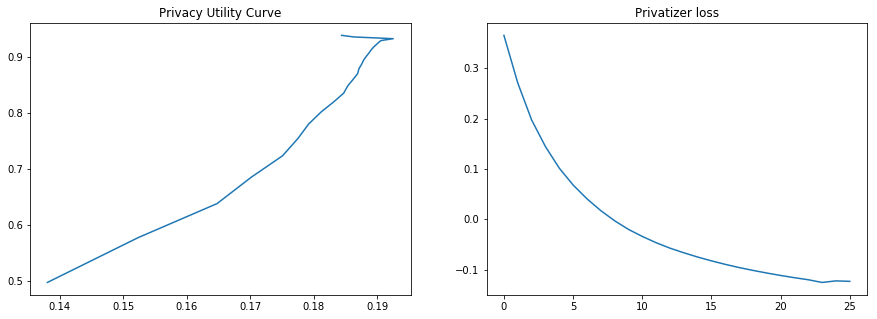

In [74]:
macro_loss = []
privacy = []
utility = []

delta1 = 1
delta2 = 0
count_iter = 0
max_iter = 200

while abs(delta1 - delta2) >= 0.001 and count_iter < max_iter:
    count_iter += 1

    x, trueusers = sampleChania(Chania, 100)
    y = p5(p4(p3(p2(p1(x)))))
    m1 = i4(i3(i2(i1(x[:,2:]))))
    m1_target = tf.keras.backend.reshape(x[:,1], (100,1))
    users = a2(a1(y))
    combined = a2(a1(p5(p4(p3(p2(p1(x)))))))

    delta1 = privatizer_loss.eval(session=sess)
    m1plot = train(m1_train, m1_loss, 1000)
    aplot = train(a_train, adversary_loss, 1000)
    pplot = train(p_train, privatizer_loss, 1)
    delta2 = privatizer_loss.eval(session=sess)

    if False:
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        fig.subplots_adjust(hspace=0.3)
        ax[0].plot(m1plot)
        ax[0].set_title("Loss training Map")
        ax[1].plot(aplot)
        ax[1].set_title("Loss training Adversary")
        fig.suptitle("Iteration %d"%(count_iter))
        
    if count_iter%10 == 0:
        print(count_iter)
        print("Map error:", map_error.eval(session=sess))
        print("Adversary error:", adversary_loss.eval(session=sess))
        print("Privatizer loss:", privatizer_loss.eval(session=sess))
    
    privacy.append(adversary_loss.eval(session=sess))
    utility.append(1-map_error.eval(session=sess))
    macro_loss.extend(pplot)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(privacy, utility)
ax[0].set_title("Privacy Utility Curve")
ax[1].plot(macro_loss)
ax[1].set_title("Privatizer loss")

Text(0.5, 1.0, 'Obfuscated Received Signal Strengths')

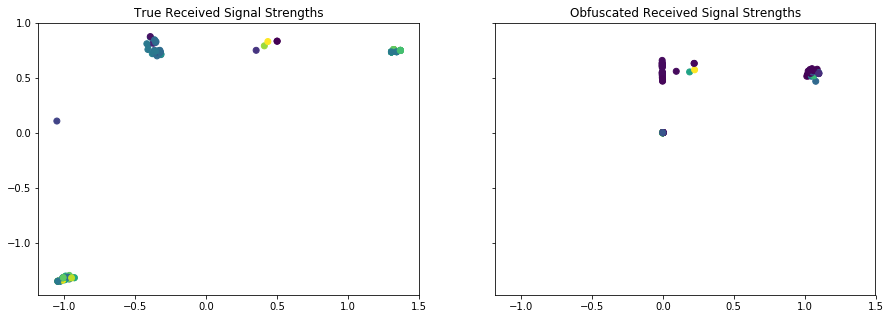

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)

ax[0].scatter(x.eval(session=sess)[:,3], x.eval(session=sess)[:,2], c=x.eval(session=sess)[:,1])
ax[0].set_title("True Received Signal Strengths")

ax[1].scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], c=y.eval(session=sess)[:,1])
ax[1].set_title("Obfuscated Received Signal Strengths")

Text(0.5, 1.0, 'True Labels (Obfuscated)')

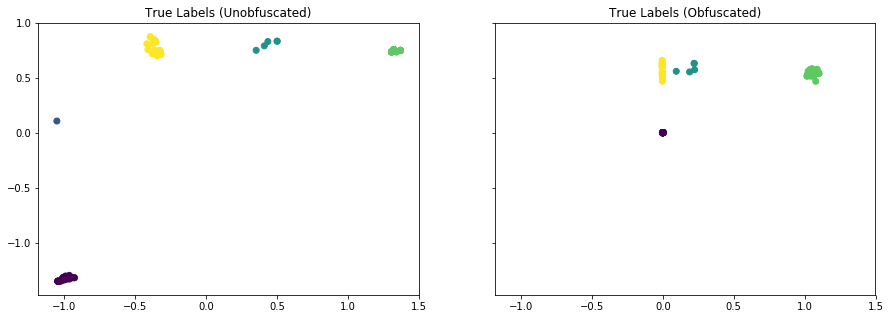

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)

ax[0].scatter(x.eval(session=sess)[:,3], x.eval(session=sess)[:,2], c=trueusers.eval(session=sess))
ax[0].set_title("True Labels (Unobfuscated)")

ax[1].scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], c=trueusers.eval(session=sess))
ax[1].set_title("True Labels (Obfuscated)")

Text(0.5, 1.0, 'Predicted Labels (Obfuscated)')

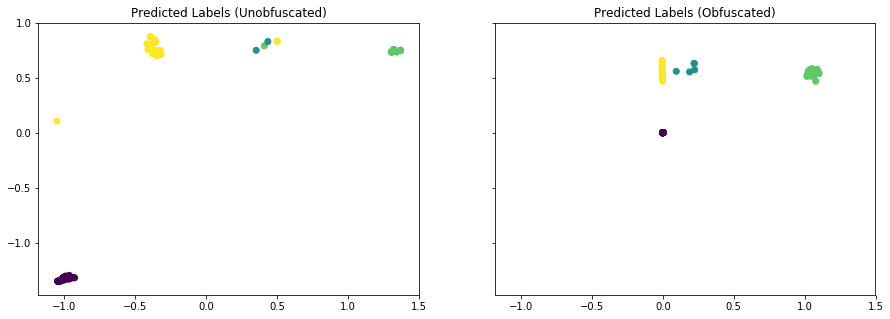

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)

ax[0].scatter(x.eval(session=sess)[:,3], x.eval(session=sess)[:,2], c=np.argmax(a2(a1(x)).eval(session=sess), axis=1))
ax[0].set_title("Predicted Labels (Unobfuscated)")

ax[1].scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], c=np.argmax(a2(a1(y)).eval(session=sess), axis=1))
ax[1].set_title("Predicted Labels (Obfuscated)")

Text(0.5, 1.0, 'Map created from Obfuscated Data')

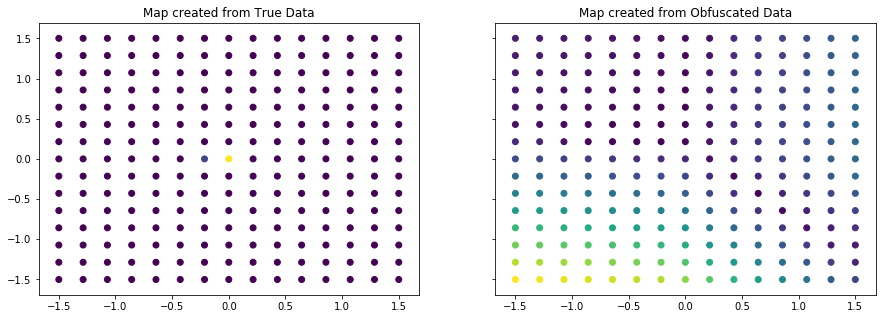

In [78]:
sess_plot = tf.Session()
keras.backend.set_session(sess_plot)

py = tf.constant(y.eval(session=sess), dtype=tf.float32)

pi1 = keras.layers.Dense(4, activation=tf.nn.relu)
pi2 = keras.layers.Dense(4, activation=tf.nn.relu)
pi3 = keras.layers.Dense(4, activation=tf.nn.relu)
pi8 = keras.layers.Dense(1)

pm1 = pi8(pi3(pi2(pi1(py[:,2:]))))
pm1_vars = [pi1.variables, pi2.variables, pi3.variables, pi8.variables]

pm1_target = tf.keras.backend.reshape(py[:,1], (100,1))
pm1_train = tf.train.GradientDescentOptimizer(0.1)
pm1_loss = tf.placeholder(tf.float32)

sess_plot.run(tf.global_variables_initializer())

pm1_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(pm1, pm1_target))
pm1_train = pm1_train.minimize(pm1_loss, var_list = pm1_vars)

pm1plot = train(pm1_train, pm1_loss, 1000, sess=sess_plot)

testpoints = np.mgrid[-1.5:1.5:15j, -1.5:1.5:15j].reshape(2,-1).T
grid = tf.constant(testpoints, dtype=tf.float32)
outputmap = pi8(pi3(pi2(pi1(grid)))).eval(session=sess_plot)

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

inputmap = i4(i3(i2(i1(grid)))).eval(session=sess)

ax[0].scatter(testpoints[:,1], testpoints[:,0], c=inputmap[:,0])
ax[0].set_title("Map created from True Data")

ax[1].scatter(testpoints[:,1], testpoints[:,0], c=outputmap[:,0])
ax[1].set_title("Map created from Obfuscated Data")

# TEST SECTION

### Adversary in isolation

one relu layer with 7 units, one softmax layer with 5 outputs  
learning rate 0.08, stop early at delta = 0.0001

In [50]:
np.random.seed(0)

sess = tf.Session()
keras.backend.set_session(sess)
x, trueusers = sampleChania(Chania, 100)

a1 = keras.layers.Dense(7, activation=tf.nn.relu)
a5 = keras.layers.Dense(5, activation=tf.nn.softmax)

users = a5(a1(x))
a_vars = [a1.variables, a5.variables]


a_train = tf.train.GradientDescentOptimizer(0.08)
sess.run(tf.global_variables_initializer())

adversary_loss = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, users))
a_train = a_train.minimize(adversary_loss, var_list = a_vars)

after 826 iterations...
final loss 0.04096859


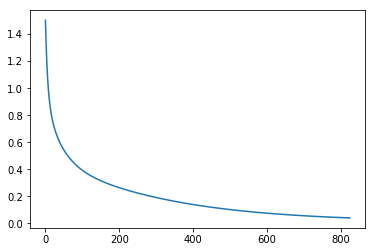

In [51]:
train(a_train, adversary_loss, 1000, True)

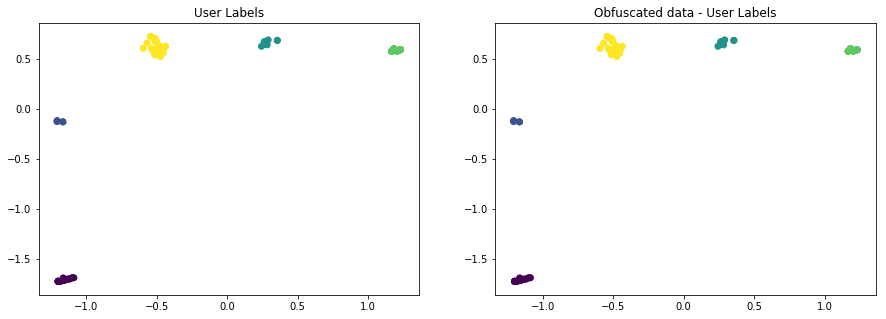

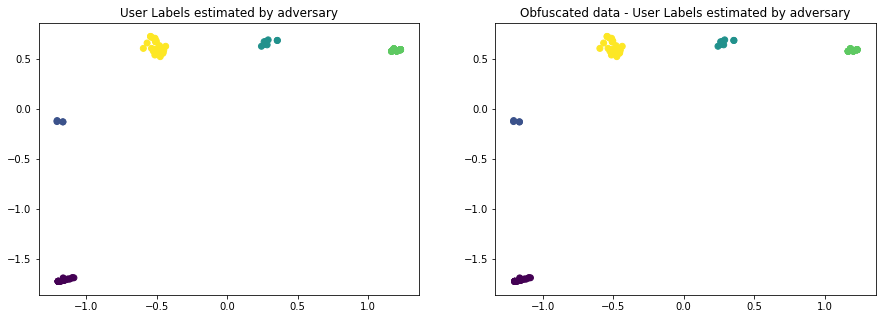

In [52]:
plot_users(x, x, users, trueusers, sess)

### Map in isolation

In [44]:
np.random.seed(0)

sess = tf.Session()
keras.backend.set_session(sess)

x, trueusers = sampleChania(Chania, 80)

i1 = keras.layers.Dense(4, activation=tf.nn.relu)
i2 = keras.layers.Dense(4, activation=tf.nn.relu)
i3 = keras.layers.Dense(4, activation=tf.nn.relu)
# i4 = keras.layers.Dense(16, activation=tf.nn.relu)
# i5 = keras.layers.Dense(16, activation=tf.nn.relu)
# i6 = keras.layers.Dense(16, activation=tf.nn.relu)
# i7 = keras.layers.Dense(16, activation=tf.nn.relu)
i8 = keras.layers.Dense(1)

# m1 = i8(i7(i6(i5(i4(i3(i2(i1(x[:,2:]))))))))
m1 = i8(i3(i2(i1(x[:,2:]))))
# m1_vars = [i1.variables, i2.variables, i3.variables, i4.variables, 
#            i5.variables, i6.variables, i7.variables, i8.variables]
m1_vars = [i1.variables, i2.variables, i3.variables, i8.variables]

m1_target = tf.keras.backend.reshape(x[:,1], (80,1))
m1_train = tf.train.GradientDescentOptimizer(0.1)
m1_loss = tf.placeholder(tf.float32)

sess.run(tf.global_variables_initializer())

m1_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m1, m1_target))
m1_train = m1_train.minimize(m1_loss, var_list = m1_vars)

after 41 iterations...
final loss 0.6482523


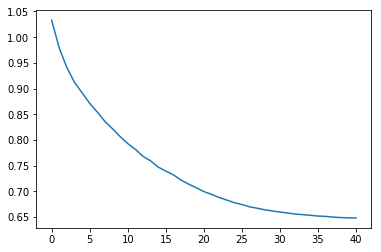

In [45]:
train(m1_train, m1_loss, 100, True)

Text(0.5, 1.0, 'True Received Signal Strengths, min=-3.0709, max=2.5768')

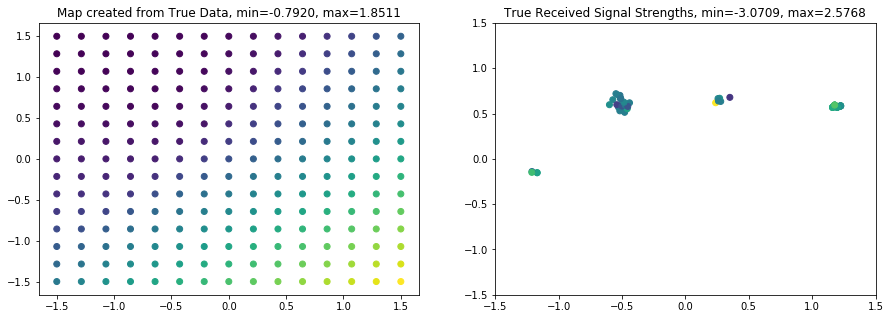

In [46]:
testpoints = np.mgrid[-1.5:1.5:15j, -1.5:1.5:15j].reshape(2,-1).T
grid = tf.constant(testpoints, dtype=tf.float32)

inputmap = i8(i3(i2(i1(grid)))).eval(session=sess)
xarray = x.eval(session=sess)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(testpoints[:,1], testpoints[:,0], c=inputmap[:,0])
ax[0].set_title("Map created from True Data, min=%.4f, max=%.4f"%(np.min(inputmap[:,0]), np.max(inputmap[:,0])))
    
ax[1].scatter(xarray[:,3], xarray[:,2], c=xarray[:,1])
ax[1].set_xlim([-1.5,1.5])
ax[1].set_ylim([-1.5,1.5])
ax[1].set_title("True Received Signal Strengths, min=%.4f, max=%.4f"%(np.min(xarray[:,1]), np.max(xarray[:,1])))

### Privatizer in Isolation

In [842]:
_sess = tf.Session()
keras.backend.set_session(_sess)

In [843]:
_x, _trueusers = sampleChania(Chania, 5)

In [844]:
init = keras.initializers.Identity(gain=1.0)

_p1 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu) # TODO
_p2 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
_p3 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
_p4 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
_p5 = keras.layers.Dense(4)

_y = _p5(_p4(_p3(_p2(_p1(_x)))))
_p_vars = [_p1.variables, _p2.variables, _p3.variables, _p4.variables, _p5.variables]

In [845]:
_p_train = tf.train.GradientDescentOptimizer(0.5) # TODO

In [846]:
_privatizer_loss = tf.placeholder(tf.float32)

In [847]:
_sess.run(tf.global_variables_initializer())

In [848]:
_privatizer_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(_x, _y))
_p_train = _p_train.minimize(_privatizer_loss, var_list = _p_vars)

In [855]:
train(_p_train, _privatizer_loss, 100, sess=_sess)

[0.31329244,
 0.23783453,
 0.19674805,
 0.17871472,
 0.62472284,
 0.67775524,
 0.58706343,
 0.40465078,
 0.23360972,
 0.22467391,
 0.16576698,
 0.20148757,
 0.14356022,
 0.16138431,
 0.14612587,
 0.1638451,
 0.15310262,
 0.16192342,
 0.16185935]

In [856]:
_xarray = _x.eval(session=_sess)

In [857]:
_yarray = _y.eval(session=_sess)

In [858]:
msearray = tf.keras.losses.mean_squared_error(_x, _y).eval(session=_sess)

In [859]:
_xarray

array([[-1.1854978 , -0.5647102 ,  0.8125062 ,  0.80874366],
       [ 1.1371523 , -0.8784381 , -1.2460182 , -1.2477574 ],
       [-1.2188804 ,  1.945113  , -1.2032249 , -1.2013831 ],
       [ 0.7138603 , -0.2509823 ,  0.8125062 ,  0.80874366],
       [ 0.5533656 , -0.2509823 ,  0.82423055,  0.8316533 ]],
      dtype=float32)

In [860]:
_yarray

array([[-0.09422031, -0.29039252,  0.40690666,  0.34964973],
       [ 1.1848148 , -0.83729184, -1.253633  , -1.2584431 ],
       [-1.4274968 ,  2.3702123 , -1.4054091 , -1.4061847 ],
       [-0.04335663, -0.30432403,  0.5448174 ,  0.48736328],
       [-0.0386709 , -0.30495685,  0.5528917 ,  0.50550616]],
      dtype=float32)

In [865]:
tf.reduce_mean(tf.squared_difference(_xarray, _yarray)).eval(session=_sess)

0.16185935